In [1]:
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm

In [2]:
from torchvision import transforms
from torchvision.datasets import FashionMNIST
import torch.utils.data as data
from decouple import config
from dotenv import load_dotenv
import torch
load_dotenv()
DATASET_PATH = config('PATH_DATASETS')
CHECKPOINT_PATH = config('PATH_CHECKPOINT')

In [3]:
# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=False)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=False)
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

In [4]:
from model import BaseNetwork, get_model_file, load_model,save_model
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")

Using device cuda:0


In [5]:
import os
import torch.optim as optim


def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """Train a model on the training set of FashionMNIST.

    Args:
        net: Object of BaseNetwork
        model_name: (str) Name of the model, used for creating the checkpoint names
        max_epochs: Number of epochs we want to (maximally) train for
        patience: If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size: Size of batches used in training
        overwrite: Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)  # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(
            train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True
        )

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0.0, 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)  # To GPU
                optimizer.zero_grad()  # Zero-grad can be placed anywhere before "loss.backward()"
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(
                f"[Epoch {epoch+1:2i}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%"
            )

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1, len(val_scores) + 1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=") + "\n")
    return test_acc


def test_model(net, data_loader):
    """Test a model on a specified dataset.

    Args:
        net: Trained model of type BaseNetwork
        data_loader: DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0.0, 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

In [6]:
from utils import set_seed
from model import BaseNetwork
from act_func import *
act_fn_by_name = {"sigmoid": Sigmoid, "tanh": Tanh, "relu": ReLU, "leakyrelu": LeakyReLU, "elu": ELU, "swish": Swish}

In [7]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...
============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation...
Model file already exists. Skipping training...
============= Test accuracy: 87.59% ==============

Training BaseNetwork with relu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.62% ==============

Training BaseNetwork with leakyrelu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.92% ==============

Training BaseNetwork with elu activation...
Model file already exists. Skipping training...
============= Test accuracy: 87.27% ==============

Training BaseNetwork with swish activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.73% ==============



In [8]:
def visualize_activations(net, color="C0"):
    activations = {}

    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()

    # Plotting
    columns = 4
    rows = math.ceil(len(activations) / columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns * 2.7, rows * 2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index // columns][fig_index % columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

In [10]:
import math

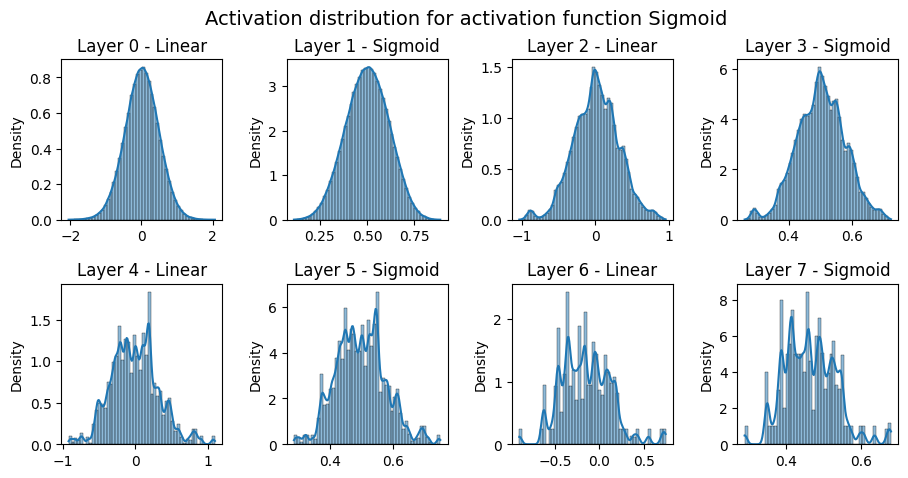

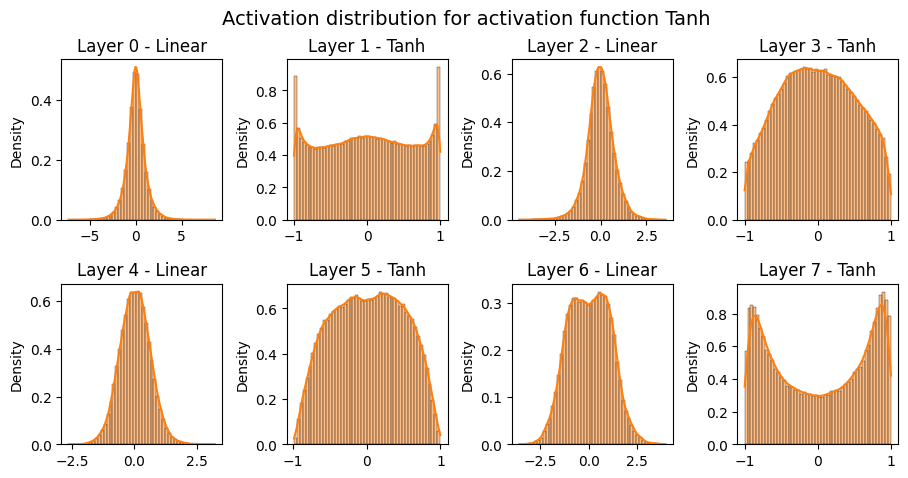

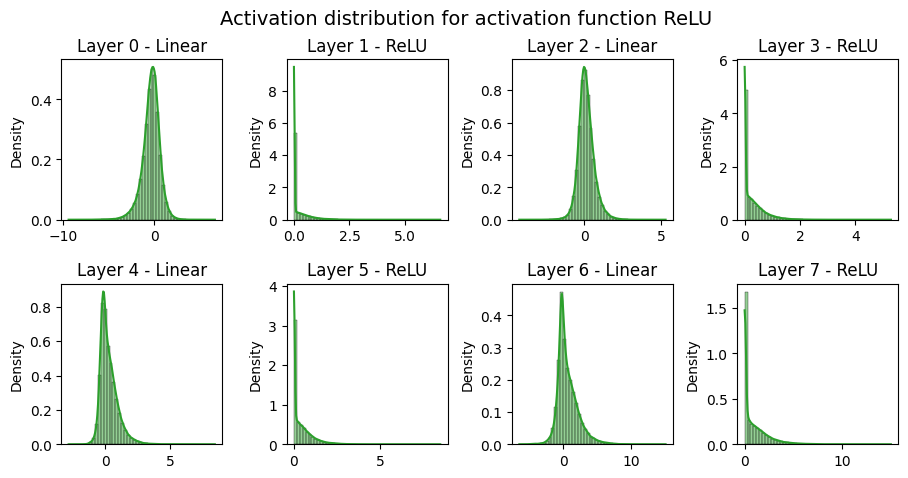

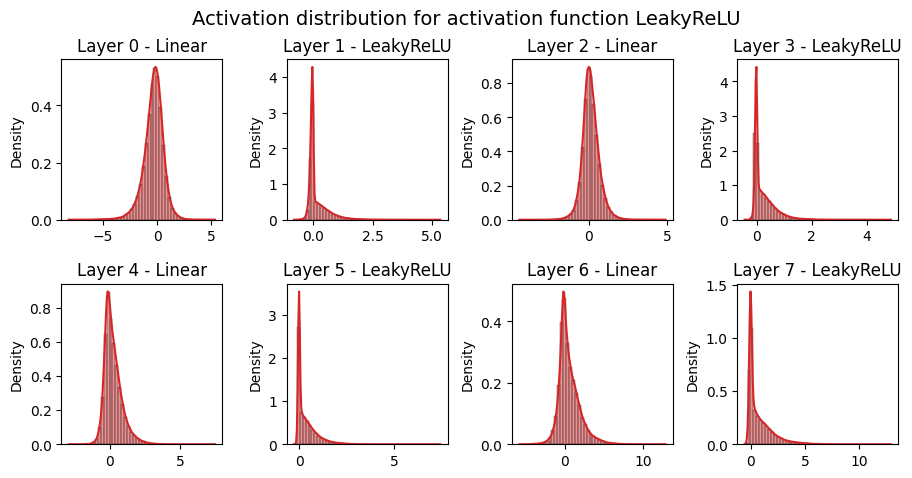

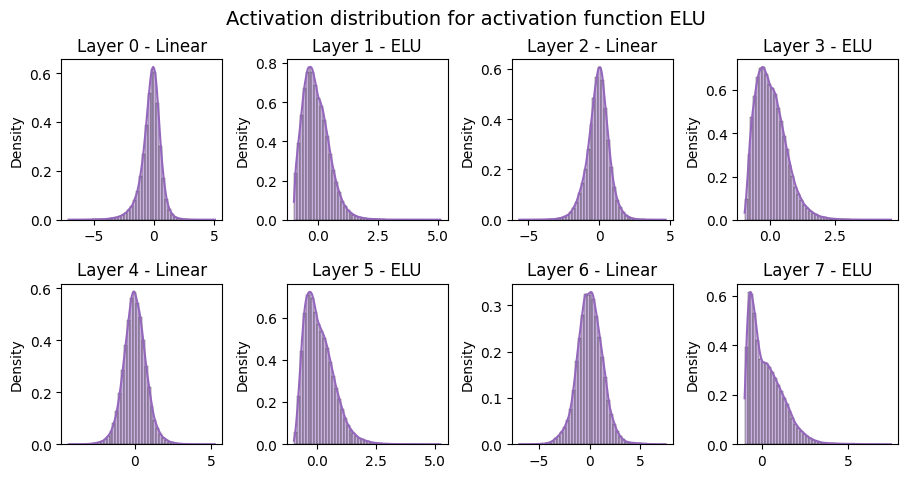

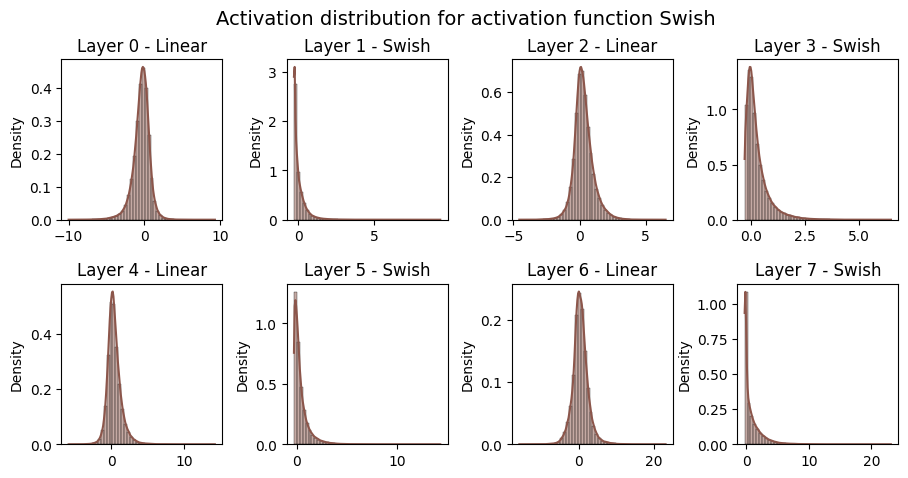

In [11]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}")

In [12]:
@torch.no_grad()
def measure_number_dead_neurons(net):
    """Function to measure the number of dead neurons in a trained neural network.

    For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time, we
    set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    """
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool)
        for layer in net.layers[:-1]
        if isinstance(layer, nn.Linear)
    ]  # Same shapes as hidden size in BaseNetwork

    net.eval()
    for imgs, labels in tqdm(train_loader, leave=False):  # Run through whole training set
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        for layer in net.layers[:-1]:
            imgs = layer(imgs)
            if isinstance(layer, ActivationFunction):
                # Are all activations == 0 in the batch, and we did not record the opposite in the last batches?
                neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print(
        "In percentage:",
        ", ".join(
            [f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]
        ),
    )

In [16]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

Number of dead neurons: [0, 0, 3, 10]
In percentage: 0.00%, 0.00%, 1.17%, 7.81%


In [15]:
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

Number of dead neurons: [0, 0, 0, 3]
In percentage: 0.00%, 0.00%, 0.00%, 2.34%


In [17]:
set_seed(42)
net_relu = BaseNetwork(
    act_fn=ReLU(),
    hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128],
).to(device)
measure_number_dead_neurons(net_relu)

Number of dead neurons: [0, 0, 7, 28, 89, 60, 58, 61, 72, 56]
In percentage: 0.00%, 0.00%, 2.73%, 10.94%, 34.77%, 46.88%, 45.31%, 47.66%, 56.25%, 43.75%


In other words, the weights of this neuron will never be updated again. Such a neuron can be considered as a dead neuron, which is considered a kind of permanent “brain damage” in biological terms. A dead neuron can be thought of as a natural Dropout. But the problem is if every neuron in a specific hidden layer is dead, it cuts the gradient to the previous layer resulting in zero gradients to the layers behind it. It can be fixed by using smaller learning rates so that the big gradient doesn’t set a big negative weight and bias in a ReLU neuron. Another ﬁx is to use the Leaky ReLU, which allows the neurons outside the active interval to leak some gradient backward.

-> Fix by using smaler learning rates or using Leaky ReLU